# INTRODUCTION

We try to predict the genetic disorder of patients based on multiple features

# IMPORT & SETUP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Dense, Input, BatchNormalization, Layer
from tensorflow.keras.activations import linear, relu, sigmoid
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall, MeanSquaredError, AUC
from keras import models
from keras.models import load_model
from tensorflow.keras import layers

import seaborn as sns
import time
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

import xgboost as xgb
#from lazypredict.Supervised import LazyClassifier
#from pycaret.classification import *

import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, mean_absolute_error, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression


# THE DATASET

##### Features: 
###### We see here an example entry from the dataset, we count 45 features, two of which are target features

In [2]:
file_path = 'data/train.csv' 
data = pd.read_csv(file_path)

i = 0
for column in data.columns:
    print(i, "\t ", column)
    i = i+1


0 	  Patient Id
1 	  Patient Age
2 	  Genes in mother's side
3 	  Inherited from father
4 	  Maternal gene
5 	  Paternal gene
6 	  Blood cell count (mcL)
7 	  Patient First Name
8 	  Family Name
9 	  Father's name
10 	  Mother's age
11 	  Father's age
12 	  Institute Name
13 	  Location of Institute
14 	  Status
15 	  Respiratory Rate (breaths/min)
16 	  Heart Rate (rates/min
17 	  Test 1
18 	  Test 2
19 	  Test 3
20 	  Test 4
21 	  Test 5
22 	  Parental consent
23 	  Follow-up
24 	  Gender
25 	  Birth asphyxia
26 	  Autopsy shows birth defect (if applicable)
27 	  Place of birth
28 	  Folic acid details (peri-conceptional)
29 	  H/O serious maternal illness
30 	  H/O radiation exposure (x-ray)
31 	  H/O substance abuse
32 	  Assisted conception IVF/ART
33 	  History of anomalies in previous pregnancies
34 	  No. of previous abortion
35 	  Birth defects
36 	  White Blood cell count (thousand per microliter)
37 	  Blood test result
38 	  Symptom 1
39 	  Symptom 2
40 	  Symptom 3
41 	  S

##### Target features

In [3]:
disease_col = 'Genetic Disorder'  
subclass_col = 'Disorder Subclass'  


grouped_data = data.groupby([disease_col, subclass_col]).size().reset_index(name='Count')
num_combinations = grouped_data.shape[0]


print("Number of entries in the dataset:", len(data))

print("\nUnique Combinations of Disease and Subclass:")
grouped_data.head(10)




Number of entries in the dataset: 22083

Unique Combinations of Disease and Subclass:


,Genetic Disorder,Disorder Subclass,Count
0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy,587
1,Mitochondrial genetic inheritance disorders,Leigh syndrome,4683
2,Mitochondrial genetic inheritance disorders,Mitochondrial myopathy,3971
3,Multifactorial genetic inheritance disorders,Alzheimer's,133
4,Multifactorial genetic inheritance disorders,Cancer,91
5,Multifactorial genetic inheritance disorders,Diabetes,1653
6,Single-gene inheritance diseases,Cystic fibrosis,3145
7,Single-gene inheritance diseases,Hemochromatosis,1228
8,Single-gene inheritance diseases,Tay-Sachs,2556


###### There are 3 genetic disorders, each with 3 subclasses. 
###### We notice that there are null entries in the target features, these will not be able to controbute to the model

c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


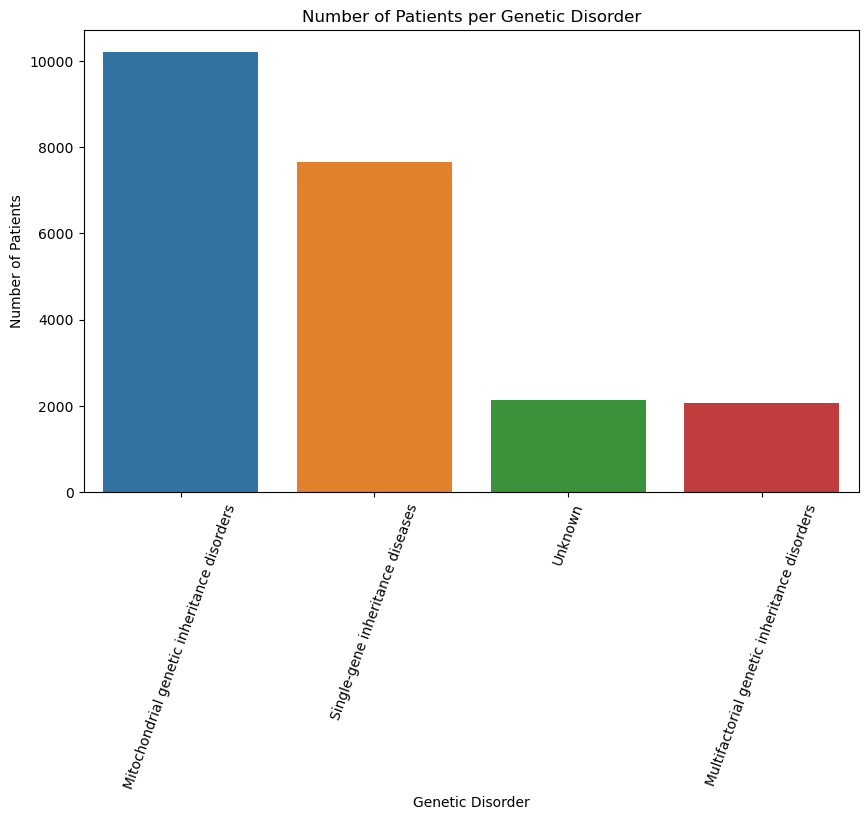

c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


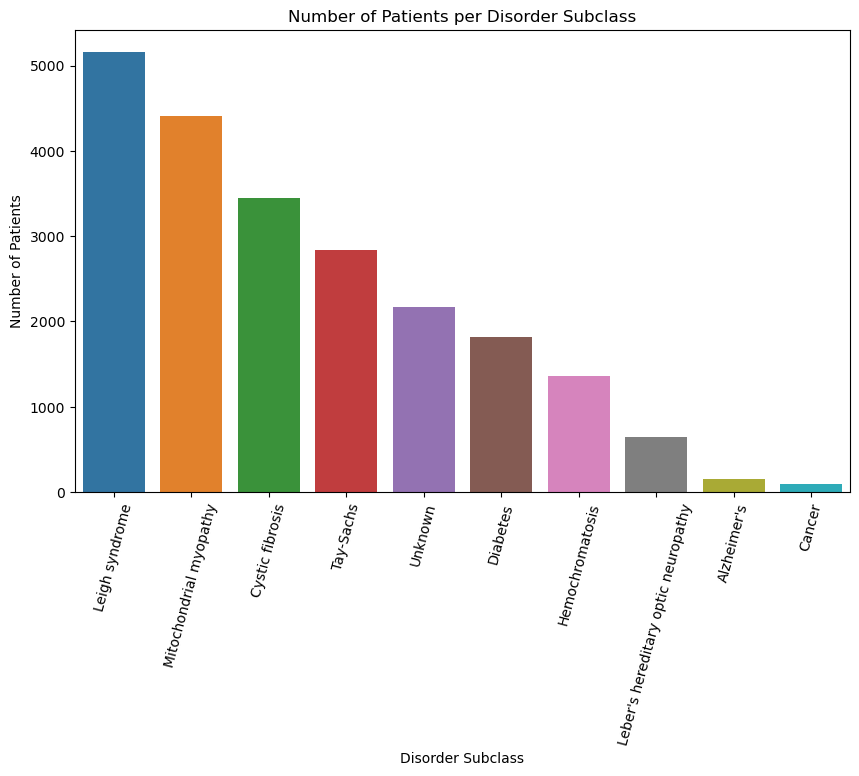

In [4]:
graph_data = data
graph_data[disease_col].fillna('Unknown', inplace=True)
graph_data[subclass_col].fillna('Unknown', inplace=True)


# Counting patients for each disease and subclass
disease_count = graph_data[disease_col].value_counts()
subclass_count = graph_data[subclass_col].value_counts()

# Plotting Bar Chart for Diseases
plt.figure(figsize=(10, 6))
sns.barplot(x=disease_count.index, y=disease_count.values) 
plt.title('Number of Patients per Genetic Disorder')
plt.ylabel('Number of Patients')
plt.xlabel('Genetic Disorder')
plt.xticks(fontsize=10, rotation=70) 
plt.show()

# Plotting Bar Chart for Subclasses
plt.figure(figsize=(10, 6))
sns.barplot(x=subclass_count.index, y=subclass_count.values)
plt.title('Number of Patients per Disorder Subclass')
plt.ylabel('Number of Patients')
plt.xlabel('Disorder Subclass')
plt.xticks(fontsize=10, rotation=75) 
plt.show()

In [5]:

for column in data.columns:
    unique_values = data[column].unique()
    nan_counts = data[column].isnull().sum()

    print(f"{column}: {unique_values}: {nan_counts}\n")
    
print(data.info())
print(data.describe())

Patient Id: ['PID0x6418' 'PID0x25d5' 'PID0x4a82' ... 'PID0x3c4f' 'PID0x13a'
 'PID0x9332']: 0

Patient Age: [ 2.  4.  6. 12. 11. 14.  3.  7.  1.  0. nan 10.  5. 13.  8.  9.]: 1427

Genes in mother's side: ['Yes' 'No']: 0

Inherited from father: ['No' 'Yes' nan]: 306

Maternal gene: ['Yes' 'No' nan]: 2810

Paternal gene: ['No' 'Yes']: 0

Blood cell count (mcL): [4.76060309 4.91066906 4.89329743 ... 5.1864702  4.85854267 4.73806671]: 0

Patient First Name: ['Richard' 'Mike' 'Kimberly' ... 'Kraig' 'Althea' 'Cathrine']: 0

Family Name: [nan 'Hoelscher' 'Stutzman' ... 'Acuff' 'Farley' 'Mose']: 9691

Father's name: ['Larre' 'Brycen' 'Nashon' ... 'Quientin' 'Bomer' 'Eban']: 0

Mother's age: [nan 41. 21. 32. 40. 45. 44. 50. 28. 30. 24. 36. 51. 23. 49. 46. 18. 38.
 37. 42. 48. 25. 19. 47. 34. 35. 22. 33. 20. 26. 31. 29. 27. 43. 39.]: 6036

Father's age: [nan 23. 22. 63. 44. 42. 56. 20. 24. 57. 48. 30. 55. 62. 43. 32. 41. 52.
 28. 31. 61. 35. 49. 50. 29. 64. 39. 34. 51. 25. 60. 53. 58. 26. 27. 59

# PRE-PROCESSING 1

---------------------------------------DATA OVERVIEW-------------------------------------
Patient Age: [ 2.  4.  6. 12. 14.  3. 11.  7.  1.  0. 10.  5. 13.  8.  9.]: 0

Genes in mother's side: [1. 0.]: 0

Inherited from father: [ 0.  1. -1.]: 236

Maternal gene: [1. 0.]: 0

Paternal gene: [0. 1.]: 0

Blood cell count (mcL): [-0.5118449   0.04212314 -0.02200419 ...  0.27672303 -0.15030127
 -0.59503787]: 0

Mother's age: [35. 41. 21. 45. 44. 50. 28. 24. 40. 36. 30. 23. 49. 46. 18. 38. 37. 42.
 51. 48. 32. 19. 47. 34. 22. 33. 20. 29. 26. 31. 43. 39. 27. 25.]: 0

Father's age: [42. 23. 22. 63. 44. 56. 20. 24. 57. 48. 30. 55. 62. 43. 32. 52. 28. 31.
 61. 35. 49. 50. 29. 64. 39. 34. 51. 25. 60. 53. 58. 26. 27. 59. 47. 38.
 54. 21. 41. 37. 33. 46. 40. 36. 45.]: 0

Status: [0. 1.]: 0

Respiratory Rate (breaths/min): [0. 1.]: 0

Heart Rate (rates/min: [0. 1.]: 0

Follow-up: [1. 0.]: 0

Gender: [ 0.5  0.  -0.5]: 0

Birth asphyxia: [-1.  0.  1.]: 5625

Autopsy shows birth defect (if applicable): 

c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


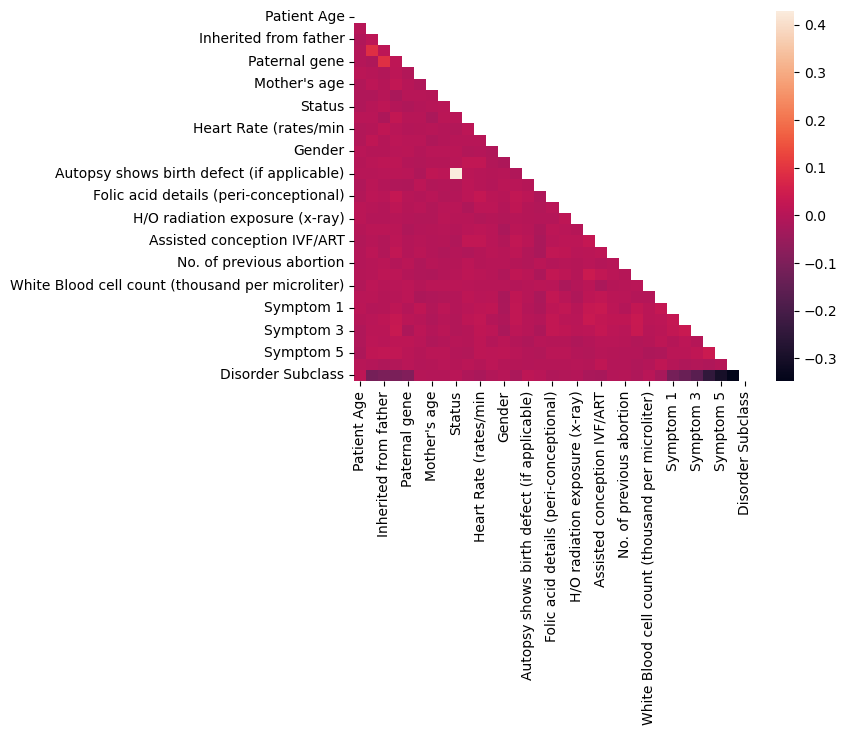

In [8]:
label_encoder = LabelEncoder()

file_path = 'data/train.csv' 
dataset = pd.read_csv(file_path)

#----------------------------------PRE PROCESS--------------------------------------#
#----------------------------------%%%%%%%%%%%%%--------------------------------------#

# remove rows where both targets NaN
dataset = dataset.dropna(subset=['Genetic Disorder', 'Disorder Subclass'], how='all')

# remove irrelevant features
columns_to_drop = ['Institute Name', 'Location of Institute', "Father's name", 
                   'Patient First Name', 'Family Name', 'Patient Id', 'Parental consent', 
                'Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5']
dataset = dataset.drop(columns=columns_to_drop)


# Fill missing values in 'Genetic Disorder' based on 'Disorder Subclass'
subclass_to_disorder = {
    'Leber\'s hereditary optic neuropathy': 'Mitochondrial genetic inheritance disorders',
    'Leigh syndrome': 'Mitochondrial genetic inheritance disorders',
    'Mitochondrial myopathy': 'Mitochondrial genetic inheritance disorders',
    'Alzheimer\'s': 'Multifactorial genetic inheritance disorders',
    'Cancer': 'Multifactorial genetic inheritance disorders',
    'Diabetes': 'Multifactorial genetic inheritance disorders',
    'Cystic fibrosis': 'Single-gene inheritance diseases',
    'Hemochromatosis': 'Single-gene inheritance diseases',
    'Tay-Sachs': 'Single-gene inheritance diseases',
}


dataset['Genetic Disorder'] = dataset.apply(
    lambda row: subclass_to_disorder[row['Disorder Subclass']] 
    if pd.isna(row['Genetic Disorder']) else row['Genetic Disorder'],
    axis=1
)


#----------------------------------PRE PROCESS--------------------------------------#
#----------------------------------%%%%%%%%%%%%%--------------------------------------#



#  NUMERICAL --> MEDIAN IMPUTER
imputer = SimpleImputer(strategy='median')
dataset['Patient Age'] = imputer.fit_transform(dataset[['Patient Age']])
dataset["Mother\'s age"] = imputer.fit_transform(dataset[['Mother\'s age']])
dataset["Father\'s age"] = imputer.fit_transform(dataset[['Father\'s age']])
dataset['No. of previous abortion'] = imputer.fit_transform(dataset[['No. of previous abortion']])
dataset['White Blood cell count (thousand per microliter)'] = imputer.fit_transform(dataset[['White Blood cell count (thousand per microliter)']])


# SCALE
robust_scaler = RobustScaler()
dataset['White Blood cell count (thousand per microliter)'] = robust_scaler.fit_transform(dataset[['White Blood cell count (thousand per microliter)']])
dataset['Blood cell count (mcL)'] = robust_scaler.fit_transform(dataset[['Blood cell count (mcL)']])
dataset['No. of previous abortion'] = robust_scaler.fit_transform(dataset[['No. of previous abortion']])




# CATEGORIAL BINARY
mode_imputer = SimpleImputer(strategy='most_frequent')
dataset['Autopsy shows birth defect (if applicable)'] = dataset['Autopsy shows birth defect (if applicable)'].replace({'Yes': 1.0, 'No': 0.0, 'Not applicable': 0.0}).fillna(0.0)
#dataset['Parental consent'] = dataset['Parental consent'].replace('Yes', 1.0).fillna(0.0)
dataset['H/O substance abuse'] = dataset['H/O substance abuse'].replace({'No': 0.0, 'Yes':1.0, 'Not applicable':0.0, '-':0.0}).fillna(-1.0)
dataset['Inherited from father'] = dataset['Inherited from father'].replace({'No': 0.0, 'Yes':1.0}).fillna(-1.0)
dataset['Maternal gene'] = dataset['Maternal gene'].replace({'No': 0.0, 'Yes':1.0}).fillna(0.0)
dataset['History of anomalies in previous pregnancies'] = dataset['History of anomalies in previous pregnancies'].replace({'Yes': 1.0, 'No': 0.0}).fillna(0.0)
dataset['H/O serious maternal illness'] = dataset['H/O serious maternal illness'].replace({'Yes': 1.0, 'No': 0.0}).fillna(0.0)
dataset['H/O radiation exposure (x-ray)'] = dataset['H/O radiation exposure (x-ray)'].replace({'No': 0.0, '-': 0.0, 'Not applicable': 0.0, 'Yes':1.0}).fillna(0.0)

dataset['Place of birth'] = dataset['Place of birth'].replace({'Institute': 1.0, 'Home': 0.0})
dataset['Place of birth'] = mode_imputer.fit_transform(dataset[['Place of birth']])
# NaN non imputed --> -1.0
dataset['Birth asphyxia'] = dataset['Birth asphyxia'].replace({'No': 0.0, 'No record': 0.0, 'Not available': -1.0, 'Yes':1.0}).fillna(-1.0)

dataset['Respiratory Rate (breaths/min)'] = dataset['Respiratory Rate (breaths/min)'].replace({'Normal (30-60)': 0.0, 'Tachypnea': 1.0})
dataset['Respiratory Rate (breaths/min)'] = mode_imputer.fit_transform(dataset[['Respiratory Rate (breaths/min)']]) 

dataset['Heart Rate (rates/min'] = dataset['Heart Rate (rates/min'].replace({'Normal': 0.0, 'Tachycardia': 1.0})
dataset['Heart Rate (rates/min'] = mode_imputer.fit_transform(dataset[['Heart Rate (rates/min']])
dataset['Follow-up'] = dataset['Follow-up'].replace({'High': 1.0, 'Low': 0.0})
dataset['Follow-up'] = mode_imputer.fit_transform(dataset[['Follow-up']])

dataset['Folic acid details (peri-conceptional)'] = dataset['Folic acid details (peri-conceptional)'].replace({'Yes': 1.0, 'No': 0.0}).fillna(-1.0)
dataset['Assisted conception IVF/ART'] = dataset['Assisted conception IVF/ART'].replace({'Yes': 1.0, 'No': 0.0}).fillna(-1.0)
dataset['Birth defects'] = dataset['Birth defects'].replace({'Multiple': 1.0, 'Singular': 0.0}).fillna(-1.0)

# CATEGORIAL MULTICLASS
dataset['Gender'] = dataset['Gender'].replace({'Male': 1.0, 'Female': 0.0, 'Ambiguous': 2.0}).fillna(2.0)
dataset['Gender'] = robust_scaler.fit_transform(dataset[['Gender']])
dataset['Blood test result'] = dataset['Blood test result'].replace({'normal': 0.0, 'inconclusive': -1.0, 'slightly abnormal': 0.5, 'abnormal': 1.0}).fillna(-1.0)
dataset['Blood test result'] = robust_scaler.fit_transform(dataset[['Blood test result']])

# BINARY FEATURES WITH NO NaN
dataset["Genes in mother's side"] = dataset["Genes in mother's side"].replace({'Yes': 1.0, 'No': 0.0})
dataset["Paternal gene"] = dataset["Paternal gene"].replace({'Yes': 1.0, 'No': 0.0})
dataset["Status"] = dataset["Status"].replace({'Alive': 0.0, 'Deceased': 1.0})

dataset['Symptom 1'] = dataset['Symptom 1'].fillna(-1.0)
dataset['Symptom 2'] = dataset['Symptom 2'].fillna(-1.0)
dataset['Symptom 3'] = dataset['Symptom 3'].fillna(-1.0)
dataset['Symptom 4'] = dataset['Symptom 4']
dataset['Symptom 5'] = dataset['Symptom 5']
dataset = dataset.dropna(subset=['Symptom 4', 'Symptom 5'])


#-------------------------------------------------------%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--------------------------------#


print("---------------------------------------DATA OVERVIEW-------------------------------------")
i=1
for column in dataset.columns:
    i=i+1
    unique_values = dataset[column].unique()
    nan_counts = (dataset[column] == -1.0).sum()

    print(f"{column}: {unique_values}: {nan_counts}\n")
print(i)
print("---------------------------------------END DATA OVERVIEW-------------------------------------")    


heat_data = dataset.copy()
heat_data['Genetic Disorder'] = label_encoder.fit_transform(heat_data['Genetic Disorder'])
heat_data['Disorder Subclass'] = label_encoder.fit_transform(heat_data['Disorder Subclass'])

corr = heat_data.corr()
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True)
plt.show()

# PRE PROCESSING 2 (COMPLETE SUBSET DROPPING ALL NaN)

c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


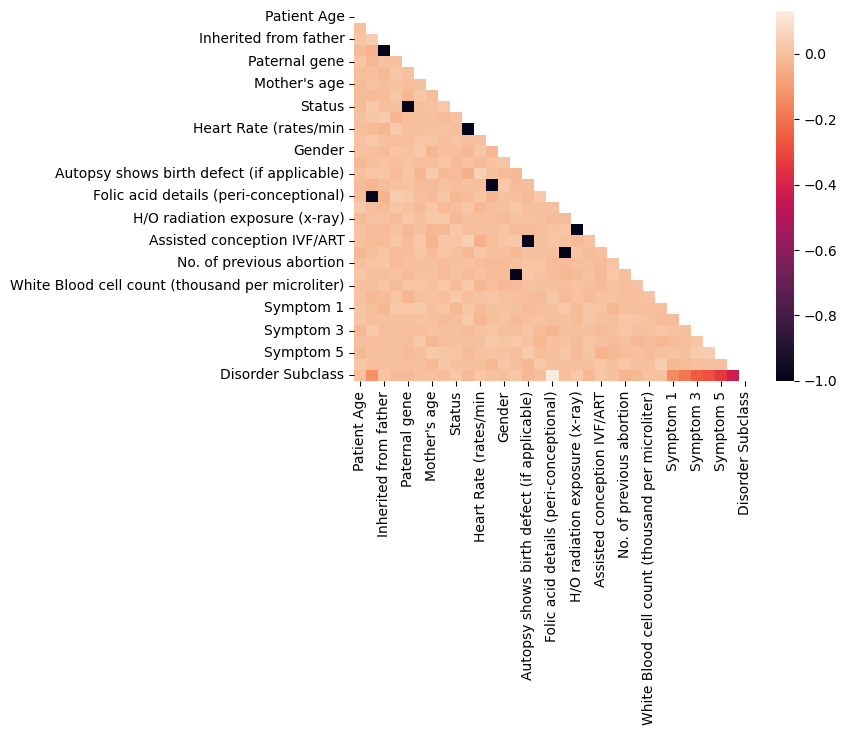

In [54]:
compl_subset = pd.read_csv('data/train.csv')

compl_subset = compl_subset.dropna()

label_encoder = LabelEncoder()


# remove irrelevant features
columns_to_drop = ['Institute Name', 'Location of Institute', "Father's name", 
                   'Patient First Name', 'Family Name', 'Patient Id',
                     'Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5', 'Parental consent']
compl_subset = compl_subset.drop(columns=columns_to_drop)


compl_subset['Autopsy shows birth defect (if applicable)'] = compl_subset['Autopsy shows birth defect (if applicable)'].replace({'Yes': 1.0, 'No': 0.0, 'Not applicable': 0.0})
compl_subset['H/O radiation exposure (x-ray)'] = compl_subset['H/O radiation exposure (x-ray)'].replace({'No': 0.0, '-': 0.0, 'Not applicable': 0.0, 'Yes':1.0})
compl_subset['H/O substance abuse'] = compl_subset['H/O substance abuse'].replace({'No': 0.0, 'Yes':1.0, 'Not applicable':0.0, '-':0.0})
compl_subset['Birth asphyxia'] = compl_subset['Birth asphyxia'].replace({'No': 0.0, 'No record': 0.0, 'Not available': 0.0, 'Yes':1.0})



compl_subset['Gender'] = label_encoder.fit_transform(compl_subset['Gender'])
compl_subset['Blood test result'] = label_encoder.fit_transform(compl_subset['Blood test result'])

compl_subset['Birth defects'] = compl_subset['Birth defects'].replace({'Multiple': 1.0, 'Singular': 0.0})
compl_subset['Place of birth'] = compl_subset['Place of birth'].replace({'Institute': 1.0, 'Home': 0.0})
compl_subset['Respiratory Rate (breaths/min)'] = compl_subset['Respiratory Rate (breaths/min)'].replace({'Normal (30-60)': 0.0, 'Tachypnea': 1.0})
compl_subset['Heart Rate (rates/min'] = compl_subset['Heart Rate (rates/min'].replace({'Normal': 0.0, 'Tachycardia': 1.0})
compl_subset['Follow-up'] = compl_subset['Follow-up'].replace({'High': 1.0, 'Low': 0.0})
compl_subset['Status'] = compl_subset['Status'].replace({'Alive': 0.0, 'Deceased': 1.0})


columns_to_replace = [
    'Inherited from father', 'Maternal gene', 
    'History of anomalies in previous pregnancies', 
    'H/O serious maternal illness', 
    'Folic acid details (peri-conceptional)', 
    'Assisted conception IVF/ART', 
    "Genes in mother's side", 
    'Paternal gene', 
    'Status'
]
for col in columns_to_replace:
    compl_subset[col] = compl_subset[col].replace({'Yes': 1.0, 'No': 0.0})


columns_to_scale = [
    'Blood test result', 
    'White Blood cell count (thousand per microliter)', 
    'No. of previous abortion', 
    'Gender', 
    'Blood cell count (mcL)',
    "Mother's age", 
    "Father's age", 
    "Patient Age",
    'No. of previous abortion',
    'Gender'
]

scaler = StandardScaler()
for col in columns_to_scale:
    compl_subset[col] = scaler.fit_transform(compl_subset[[col]])



columns_to_encode = [
    'Birth defects', 'Place of birth', 'Respiratory Rate (breaths/min)', 
    'Heart Rate (rates/min', 'Follow-up', 'Status', 
    'Autopsy shows birth defect (if applicable)', 'H/O radiation exposure (x-ray)', 
    'H/O substance abuse', 'Birth asphyxia', 'Inherited from father', 'Maternal gene', 
    'History of anomalies in previous pregnancies', 
    'H/O serious maternal illness', 
    'Folic acid details (peri-conceptional)', 
    'Assisted conception IVF/ART', 
    "Genes in mother's side", 
    'Paternal gene', 
    'Status'
]
hot_cold_mapping = {
    1.0: [1, 0],
    0.0: [0, 1]
}
for col in columns_to_encode:
    compl_subset[col] = compl_subset[col].map(hot_cold_mapping)
    compl_subset[col] = np.array(list(compl_subset[col]))





heat_data = compl_subset.copy()
heat_data['Genetic Disorder'] = label_encoder.fit_transform(heat_data['Genetic Disorder'])
heat_data['Disorder Subclass'] = label_encoder.fit_transform(heat_data['Disorder Subclass'])

corr = heat_data.corr()
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True)
plt.show()


# PRE-PROCESSING 3 (best one so far)


c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


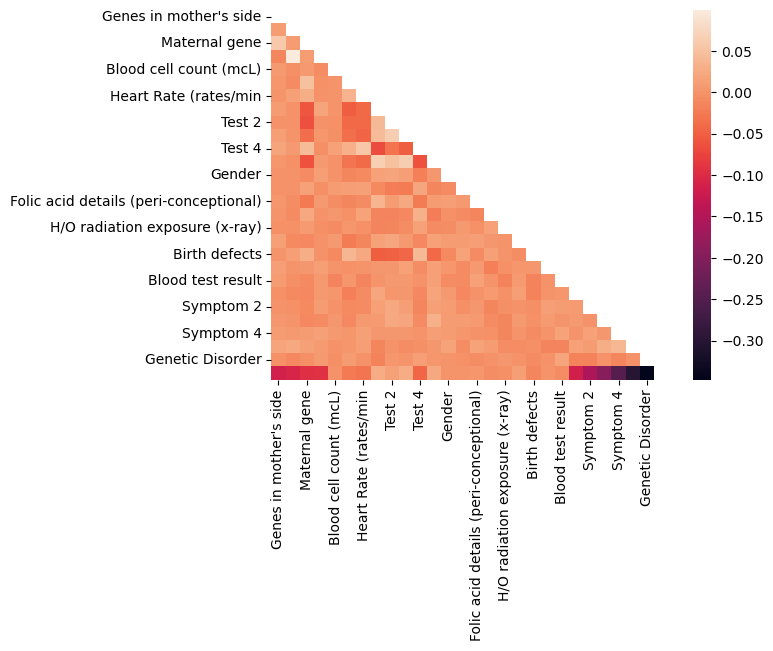

---------------------------------------DATA OVERVIEW-------------------------------------
Genes in mother's side:
    0.8251811113644136: 59.49%
    -1.2118551748555273: 40.51%

Inherited from father:
    -0.8125586723089132: 60.23%
    1.230680360789783: 39.77%

Maternal gene:
    0.9194473516886815: 48.88%
    -0.5514189001986395: 39.72%
    -2.0222851520859604: 11.39%

Paternal gene:
    -0.8726134214341036: 56.77%
    1.1459828320730412: 43.23%

Blood cell count (mcL):
NaN:  0.0

Respiratory Rate (breaths/min):
    -0.5775042930576249: 45.90%
    0.9925438887600685: 45.44%
    -2.147552474875318: 8.66%

Heart Rate (rates/min:
    -0.5790278178077202: 46.88%
    1.0063734761897303: 44.82%
    -2.1644291118051706: 8.30%

Test 1:
    -0.3067539658189557: 91.40%
    3.2599415539103216: 8.60%

Test 2:
    -0.30741546859337837: 91.37%
    3.2529267462552776: 8.63%

Test 3:
    -0.310818552582936: 91.19%
    3.217311166562907: 8.81%

Test 4:
    0.3063124437747864: 91.42%
    -3.264640468

In [55]:
label_encoder = LabelEncoder()

file_path = 'data/train.csv' 
dataset_1 = pd.read_csv(file_path)

#----------------------------------PRE PROCESS--------------------------------------#
#----------------------------------%%%%%%%%%%%%%--------------------------------------#

# remove rows where both targets NaN
dataset_1 = dataset_1.dropna(subset=['Genetic Disorder', 'Disorder Subclass'], how='all')
#dataset = dataset.dropna(subset=['Disorder Subclass'])

# remove irrelevant features
columns_to_drop = ['Institute Name', 'Location of Institute', "Father's name", 
                   'Patient First Name', 'Family Name', 'Patient Id',
                      'Autopsy shows birth defect (if applicable)',
                       "Mother\'s age", "Father\'s age", 'Parental consent', 'Status',
                       "Patient Age", 'No. of previous abortion', 'H/O substance abuse',
                       'Place of birth', 'Assisted conception IVF/ART', 'Follow-up',]
dataset_1 = dataset_1.drop(columns=columns_to_drop)


# Fill missing values in 'Genetic Disorder' based on 'Disorder Subclass'
subclass_to_disorder = {
    'Leber\'s hereditary optic neuropathy': 'Mitochondrial genetic inheritance disorders',
    'Leigh syndrome': 'Mitochondrial genetic inheritance disorders',
    'Mitochondrial myopathy': 'Mitochondrial genetic inheritance disorders',
    'Alzheimer\'s': 'Multifactorial genetic inheritance disorders',
    'Cancer': 'Multifactorial genetic inheritance disorders',
    'Diabetes': 'Multifactorial genetic inheritance disorders',
    'Cystic fibrosis': 'Single-gene inheritance diseases',
    'Hemochromatosis': 'Single-gene inheritance diseases',
    'Tay-Sachs': 'Single-gene inheritance diseases',
}

dataset_1['Genetic Disorder'] = dataset_1.apply(
    lambda row: subclass_to_disorder[row['Disorder Subclass']] 
    if pd.isna(row['Genetic Disorder']) else row['Genetic Disorder'],
    axis=1
)


#----------------------------------PRE PROCESS--------------------------------------#
#----------------------------------%%%%%%%%%%%%%--------------------------------------#



#  NUMERICAL --> MEDIAN IMPUTER
imputer = SimpleImputer(strategy='median')
#ataset['Patient Age'] = imputer.fit_transform(dataset[['Patient Age']])
#dataset['No. of previous abortion'] = imputer.fit_transform(dataset[['No. of previous abortion']])
dataset_1['White Blood cell count (thousand per microliter)'] = imputer.fit_transform(dataset_1[['White Blood cell count (thousand per microliter)']])



# CATEGORIAL BINARY

#dataset['H/O substance abuse'] = dataset['H/O substance abuse'].replace({'No': 0.0, 'Yes':1.0, 'Not applicable':0.0, '-':0.0}).fillna(0.0)
dataset_1['Inherited from father'] = dataset_1['Inherited from father'].replace({'No': 0.0, 'Yes':1.0})
dataset_1['Maternal gene'] = dataset_1['Maternal gene'].replace({'No': 0.0, 'Yes':1.0}).fillna(-1.0)
dataset_1['History of anomalies in previous pregnancies'] = dataset_1['History of anomalies in previous pregnancies'].replace({'Yes': 1.0, 'No': 0.0})
dataset_1['H/O serious maternal illness'] = dataset_1['H/O serious maternal illness'].replace({'Yes': 1.0, 'No': 0.0})
dataset_1['H/O radiation exposure (x-ray)'] = dataset_1['H/O radiation exposure (x-ray)'].replace({'No': 0.0, '-': 0.0, 'Not applicable': 0.0, 'Yes':1.0}).fillna(0.0)

#dataset['Place of birth'] = dataset['Place of birth'].replace({'Institute': 1.0, 'Home': 0.0})

dataset_1['Birth asphyxia'] = dataset_1['Birth asphyxia'].replace({'No': 0.0, 'No record': 0.0, 'Not available': 2.0, 'Yes':1.0}).fillna(0.0)

dataset_1['Respiratory Rate (breaths/min)'] = dataset_1['Respiratory Rate (breaths/min)'].replace({'Normal (30-60)': 0.0, 'Tachypnea': 1.0}).fillna(-1.0)
dataset_1['Heart Rate (rates/min'] = dataset_1['Heart Rate (rates/min'].replace({'Normal': 0.0, 'Tachycardia': 1.0}).fillna(-1.0)
#dataset['Follow-up'] = dataset['Follow-up'].replace({'High': 1.0, 'Low': 0.0}).fillna(-1.0)
dataset_1['Folic acid details (peri-conceptional)'] = dataset_1['Folic acid details (peri-conceptional)'].replace({'Yes': 1.0, 'No': 0.0})
#dataset['Assisted conception IVF/ART'] = dataset['Assisted conception IVF/ART'].replace({'Yes': 1.0, 'No': 0.0})
dataset_1['Birth defects'] = dataset_1['Birth defects'].replace({'Multiple': 2.0, 'Singular': 1.0}).fillna(0.0)

# CATEGORIAL MULTICLASS
dataset_1['Gender'] = dataset_1['Gender'].replace({'Male': 1.0, 'Female': 0.0, 'Ambiguous': 2.0}).fillna(2.0)
dataset_1['Blood test result'] = dataset_1['Blood test result'].replace({'normal': 0.0, 'inconclusive': -1.0, 'slightly abnormal': 0.5, 'abnormal': 1.0})


# BINARY FEATURES WITH NO NaN
dataset_1["Genes in mother's side"] = dataset_1["Genes in mother's side"].replace({'Yes': 1.0, 'No': 0.0})
dataset_1["Paternal gene"] = dataset_1["Paternal gene"].replace({'Yes': 1.0, 'No': 0.0})
#dataset["Status"] = dataset["Status"].replace({'Alive': 0.0, 'Deceased': 1.0})

dataset_1['Symptom 1'] = dataset_1['Symptom 1']
dataset_1['Symptom 2'] = dataset_1['Symptom 2']
dataset_1['Symptom 3'] = dataset_1['Symptom 3']
dataset_1['Symptom 4'] = dataset_1['Symptom 4']
dataset_1['Symptom 5'] = dataset_1['Symptom 5']
dataset_1 = dataset_1.dropna(subset=['Symptom 4', 'Symptom 5'])

dataset_1 = dataset_1[~dataset_1['Inherited from father'].isna()]
dataset_1["Test 1"] = dataset_1["Test 1"].fillna(1.0)
dataset_1["Test 2"] = dataset_1["Test 2"].fillna(1.0)
dataset_1["Test 3"] = dataset_1["Test 3"].fillna(1.0)
dataset_1["Test 4"] = dataset_1["Test 4"].fillna(0.0)
dataset_1["Test 5"] = dataset_1["Test 5"].fillna(1.0)

#dataset = dataset.fillna(-1.0)
#-------------------------------------------------------%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--------------------------------#
mode_imputer = SimpleImputer(strategy='most_frequent')
scaler = StandardScaler()
for column in dataset_1.columns:
    if column != 'Genetic Disorder' and column != 'Disorder Subclass':
        dataset_1[column] = scaler.fit_transform(dataset_1[[column]])
        dataset_1[column] = mode_imputer.fit_transform(dataset_1[[column]])




#dataset = dataset[~dataset['Disorder Subclass'].isin(['Cancer', "Alzheimer's"])]


heat_data = dataset_1.copy()
heat_data['Disorder Subclass'].replace(-1.0, np.nan, inplace=True)
heat_data['Genetic Disorder'] = label_encoder.fit_transform(heat_data['Genetic Disorder'])
heat_data['Disorder Subclass'] = label_encoder.fit_transform(heat_data['Disorder Subclass'])

corr = heat_data.corr()
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True)
plt.show()


print("---------------------------------------DATA OVERVIEW-------------------------------------")
i=1
for column in dataset_1.columns:
    i=i+1
    unique_values = dataset_1[column].unique()
    nan_counts = (dataset_1[column] == -1.0).sum()

    #print(f"{column}: {unique_values}: {nan_counts}\n")
#print(i)

for column in dataset_1.columns:
    value_counts = dataset_1[column].value_counts(dropna=False, normalize=True) * 100
    print(f"{column}:")
    if column not in ['White Blood cell count (thousand per microliter)', 'Blood cell count (mcL)']:
        for value, percentage in value_counts.items():
            value_str = "NaN" if pd.isna(value) else value
            print(f"    {value_str}: {percentage:.2f}%")
    else:
        print("NaN: ", ((dataset_1[column].isnull().sum() / len(dataset_1)) * 100))
    print()
total_rows = len(dataset_1)
print(f"Total number of rows in the dataset: {total_rows}")
print("---------------------------------------END DATA OVERVIEW-------------------------------------")    

# PRE-PROCESS 3 (almost everything dropped)


c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was 

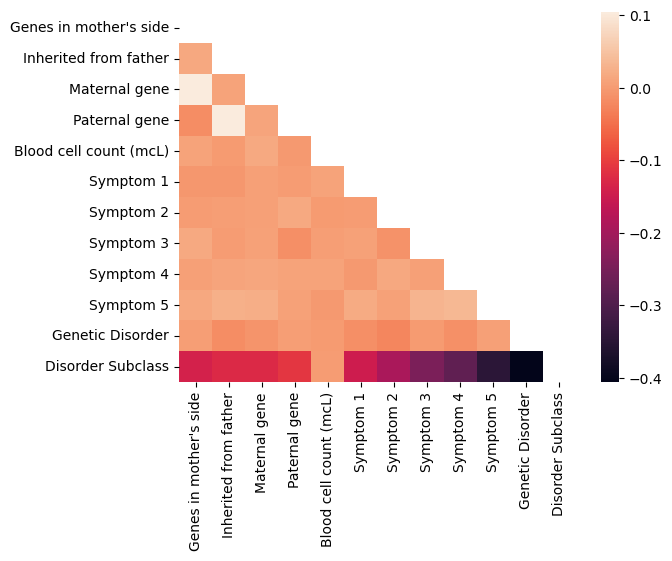

---------------------------------------DATA OVERVIEW-------------------------------------
Genes in mother's side:
    0.8232240531754516: 59.61%
    -1.2147361294202523: 40.39%

Inherited from father:
    -0.8197098817391553: 59.81%
    1.2199438146070996: 40.19%

Maternal gene:
    0.8945480140562088: 55.55%
    -1.1178829803283934: 44.45%

Paternal gene:
    -0.8696485483690373: 56.94%
    1.1498898053419713: 43.06%

Blood cell count (mcL):
NaN:  0.0

Symptom 1:
    0.8327884929133152: 59.05%
    -1.2007850834990943: 40.95%

Symptom 2:
    0.9028114383140508: 55.09%
    -1.1076510083516924: 44.91%

Symptom 3:
    0.922703306007815: 54.01%
    -1.083771992024845: 45.99%

Symptom 4:
    0.9976015041701366: 50.12%
    -1.0024042624433078: 49.88%

Symptom 5:
    -0.9249356989022294: 53.89%
    1.0811562373328887: 46.11%

Genetic Disorder:
    Mitochondrial genetic inheritance disorders: 51.18%
    Single-gene inheritance diseases: 38.30%
    Multifactorial genetic inheritance disorders: 

In [63]:

file_path = 'data/train.csv' 
dataset_2 = pd.read_csv(file_path)

#----------------------------------PRE PROCESS--------------------------------------#
#----------------------------------%%%%%%%%%%%%%--------------------------------------#

# remove rows where both targets NaN
dataset_2 = dataset_2.dropna(subset=['Genetic Disorder', 'Disorder Subclass'], how='all')


# remove all features
columns_to_drop = ['Institute Name', 'Location of Institute', "Father's name", 
                   'Patient First Name', 'Family Name', 'Patient Id',
                      'Autopsy shows birth defect (if applicable)',
                       "Mother\'s age", "Father\'s age", 'Parental consent', 'Status',
                       'Birth defects', 'Place of birth', 'Respiratory Rate (breaths/min)', 
    'Heart Rate (rates/min', 'Follow-up', 
    'Autopsy shows birth defect (if applicable)',
    'H/O substance abuse', 'Birth asphyxia', 
    'History of anomalies in previous pregnancies', 
    'H/O serious maternal illness', 
    'Folic acid details (peri-conceptional)', 
    'Assisted conception IVF/ART', 
     'Blood test result', 
    'No. of previous abortion', 
    "Mother's age", 
    "Father's age", 'White Blood cell count (thousand per microliter)',
    "Patient Age", 'Gender', 'H/O radiation exposure (x-ray)',
    'Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5'
    ]
dataset_2 = dataset_2.drop(columns=columns_to_drop)


# Fill missing values in 'Genetic Disorder' based on 'Disorder Subclass'
subclass_to_disorder = {
    'Leber\'s hereditary optic neuropathy': 'Mitochondrial genetic inheritance disorders',
    'Leigh syndrome': 'Mitochondrial genetic inheritance disorders',
    'Mitochondrial myopathy': 'Mitochondrial genetic inheritance disorders',
    'Alzheimer\'s': 'Multifactorial genetic inheritance disorders',
    'Cancer': 'Multifactorial genetic inheritance disorders',
    'Diabetes': 'Multifactorial genetic inheritance disorders',
    'Cystic fibrosis': 'Single-gene inheritance diseases',
    'Hemochromatosis': 'Single-gene inheritance diseases',
    'Tay-Sachs': 'Single-gene inheritance diseases',
}

dataset_2['Genetic Disorder'] = dataset_2.apply(
    lambda row: subclass_to_disorder[row['Disorder Subclass']] 
    if pd.isna(row['Genetic Disorder']) else row['Genetic Disorder'],
    axis=1
)



dataset_2 = dataset_2.dropna()
#-------------------------------------------------------%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--------------------------------#


label_encoder = LabelEncoder()
scaler = StandardScaler()
for column in dataset_2.columns:
    if column != 'Genetic Disorder' and column != 'Disorder Subclass':
        dataset_2[column] = label_encoder.fit_transform(dataset_2[[column]])
        dataset_2[column] = scaler.fit_transform(dataset_2[[column]])


#dataset = dataset[~dataset['Disorder Subclass'].isin(['Cancer', "Alzheimer's"])]


heat_data_3 = dataset_2.copy()
heat_data_3['Genetic Disorder'] = label_encoder.fit_transform(heat_data_3['Genetic Disorder'])
heat_data_3['Disorder Subclass'] = label_encoder.fit_transform(heat_data_3['Disorder Subclass'])

corr = heat_data_3.corr()
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True)
plt.show()


print("---------------------------------------DATA OVERVIEW-------------------------------------")

for column in dataset_2.columns:
    value_counts = dataset_2[column].value_counts(dropna=False, normalize=True) * 100
    print(f"{column}:")
    if column not in ['White Blood cell count (thousand per microliter)', 'Blood cell count (mcL)']:
        for value, percentage in value_counts.items():
            value_str = "NaN" if pd.isna(value) else value
            print(f"    {value_str}: {percentage:.2f}%")
    else:
        print("NaN: ", ((dataset_2[column].isnull().sum() / len(dataset_2)) * 100))
    print()
total_rows = len(dataset_2)
print(f"Total number of rows in the dataset: {total_rows}")
print("---------------------------------------END DATA OVERVIEW-------------------------------------")    

# Predicting only genetic disease

INFO:tensorflow:Assets written to: my_model\assets
Epoch 1/100
87/87 [==============================] - 9s 73ms/step - loss: 0.9536 - accuracy: 0.5118 - precision_28: 0.5164 - mean_squared_error: 0.1945 - recall_28: 0.3365 - val_loss: 0.9381 - val_accuracy: 0.5115 - val_precision_28: 0.5115 - val_mean_squared_error: 0.1924 - val_recall_28: 0.5115 - lr: 0.0010
Epoch 2/100
87/87 [==============================] - 6s 64ms/step - loss: 0.9012 - accuracy: 0.5120 - precision_28: 0.5806 - mean_squared_error: 0.1876 - recall_28: 0.4167 - val_loss: 0.8399 - val_accuracy: 0.5165 - val_precision_28: 0.6154 - val_mean_squared_error: 0.1791 - val_recall_28: 0.4465 - lr: 0.0010
Epoch 3/100
87/87 [==============================] - 5s 55ms/step - loss: 0.8216 - accuracy: 0.5712 - precision_28: 0.6184 - mean_squared_error: 0.1750 - recall_28: 0.4426 - val_loss: 0.8073 - val_accuracy: 0.5745 - val_precision_28: 0.6246 - val_mean_squared_error: 0.1717 - val_recall_28: 0.4235 - lr: 0.0010
Epoch 4/100
87/8

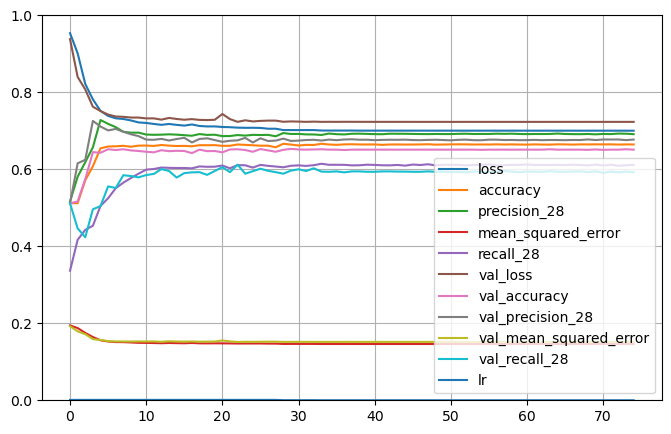

In [64]:

nn_data = dataset_2.copy()

# MAP TARGET COLUMNS TO ONE-HOT CODED ARRAYS
genetic_disorder_mapping = {
    'Mitochondrial genetic inheritance disorders': [1, 0, 0],
    'Multifactorial genetic inheritance disorders': [0, 1, 0],
    'Single-gene inheritance diseases': [0, 0, 1]
}
nn_data['Genetic Disorder'] = nn_data['Genetic Disorder'].map(genetic_disorder_mapping)

disorder_subclass_mapping = {
    "Leber's hereditary optic neuropathy": [1, 0, 0, 0, 0, 0, 0, 0, 0],  
    'Cystic fibrosis': [0, 1, 0, 0, 0, 0, 0, 0, 0],
    'Diabetes': [0, 0, 1, 0, 0, 0, 0, 0, 0],
    'Leigh syndrome': [0, 0, 0, 1, 0, 0, 0, 0, 0],
    'Tay-Sachs': [0, 0, 0, 0, 1, 0, 0, 0, 0],  
    'Mitochondrial myopathy': [0, 0, 0, 0, 0, 1, 0, 0, 0],
    'Hemochromatosis': [0, 0, 0, 0, 0, 0, 1, 0, 0],
    "Alzheimer's": [0, 0, 0, 0, 0, 0, 0, 1, 0],
    'Cancer': [0, 0, 0, 0, 0, 0, 0, 0, 1]  
}

nn_data['Disorder Subclass'] = nn_data['Disorder Subclass'].map(disorder_subclass_mapping)

# DROP SUBCLASS
nn_data = nn_data.drop(['Disorder Subclass'], axis=1)


# SHUFFLE AND SPLIT DATASET
nn_data.sample(frac=1)

validation_set = nn_data[0:2000]
test_set = nn_data[2000:3000]
train_set = nn_data[3000:]


y_train_genetic = np.array(list(train_set['Genetic Disorder']))
y_test_genetic = np.array(list(test_set['Genetic Disorder']))
y_val_genetic = np.array(list(validation_set['Genetic Disorder']))

X_train = train_set.drop(['Genetic Disorder'], axis=1)
X_test = test_set.drop(['Genetic Disorder'], axis=1)
X_val = validation_set.drop(['Genetic Disorder'], axis=1)



# BUILD LAYERS
input_layer = Input(shape=(X_train.shape[1]))
hidden1 = Dense(400, activation='sigmoid')(input_layer)
hidden2 = Dense(200, activation='sigmoid')(hidden1)
hidden3 = Dense(100, activation='sigmoid')(hidden2)
hidden4 = Dense(10, activation='sigmoid')(hidden3)
# OUTPUT LAYER
output_genetic = Dense(y_train_genetic.shape[1], activation='softmax',
                       name='genetic_output',
                       kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.L2(1e-4),
                        activity_regularizer=regularizers.L2(1e-5))(hidden4)

# CALLBACKS
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)
checkpoint_cb = ModelCheckpoint("my_model", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=15, restore_best_weights=True)

# MAKE TENSORBOARD
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = TensorBoard(run_logdir)


# BUILD MODEL
model = Model(inputs=input_layer, outputs=[output_genetic])
model.save("my_model")

model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), 
              loss={'genetic_output': 'categorical_crossentropy'}, 
              metrics=['accuracy', Precision(), MeanSquaredError(), Recall()])


history = model.fit(X_train, {'genetic_output': y_train_genetic}, epochs=100, batch_size=100,
                    validation_data=(X_val, y_val_genetic),
                    callbacks=[reduce_lr, checkpoint_cb, early_stopping_cb, tensorboard_cb])

model = models.load_model("my_model") # TRACE BACK TO BEST MODEL

 # EVALUATE MODEL
score = model.evaluate(X_test, {'genetic_output': y_test_genetic})
print(score)
print()
print('Loss: ', score[0])
print("Accuracy: ", score[1])
print("Precision: ", score[2])
print("Recall: ", score[4])
print("F1 score: ", (score[2]*score[4]*2) / (score[2]+score[4]))
print("Mean squarred error: ", score[3])


# PLOT EVALUATION
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()


# PREDICTING BOTH TARGETS

INFO:tensorflow:Assets written to: my_model_2\assets
Epoch 1/100
86/86 [==============================] - 12s 88ms/step - loss: 2.8249 - genetic_output_loss: 0.9406 - subclass_output_loss: 1.8806 - genetic_output_accuracy: 0.5188 - genetic_output_precision_30: 0.5228 - genetic_output_mean_squared_error: 0.1925 - genetic_output_recall_30: 0.3362 - subclass_output_accuracy: 0.2346 - subclass_output_precision_30: 0.0000e+00 - subclass_output_mean_squared_error: 0.0922 - subclass_output_recall_30: 0.0000e+00 - val_loss: 2.7390 - val_genetic_output_loss: 0.9323 - val_subclass_output_loss: 1.8030 - val_genetic_output_accuracy: 0.5155 - val_genetic_output_precision_30: 0.5155 - val_genetic_output_mean_squared_error: 0.1923 - val_genetic_output_recall_30: 0.5155 - val_subclass_output_accuracy: 0.2660 - val_subclass_output_precision_30: 0.0000e+00 - val_subclass_output_mean_squared_error: 0.0908 - val_subclass_output_recall_30: 0.0000e+00 - lr: 0.0010
Epoch 2/100
86/86 [========================

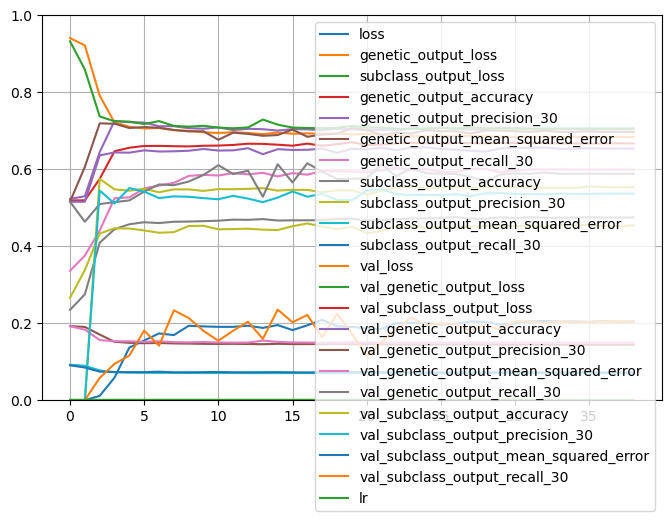

Loss:  1.840023159980774

Genetic Disorder loss:  0.6926887035369873
Genetic Disorder Accuracy:  0.6690000295639038
Genetic Disorder Precision:  0.7061556577682495
Genetic Disorder Recall:  0.6079999804496765
Genetic Disorder F1 score:  0.6534121433283786
Genetic Disorder Mean squarred error:  0.14515171945095062

Disorder Subclass loss:  1.1423691511154175
Disorder Subclass Accuracy:  0.46399998664855957
Disorder Subclass Precision:  0.5430107712745667
Disorder Subclass Recall:  0.20200000703334808
Disorder Subclass F1 score:  0.29446065160499424
Disorder Subclass Mean squarred error:  0.07098513096570969


In [66]:

nn_data_1 = dataset_2.copy()

# MAP TARGET COLUMNS TO ONE-HOT CODED ARRAYS
genetic_disorder_mapping = {
    'Mitochondrial genetic inheritance disorders': [1, 0, 0],
    'Multifactorial genetic inheritance disorders': [0, 1, 0],
    'Single-gene inheritance diseases': [0, 0, 1]
}
nn_data_1['Genetic Disorder'] = nn_data_1['Genetic Disorder'].map(genetic_disorder_mapping)


nn_data_1 = nn_data_1[~nn_data_1['Disorder Subclass'].isin(['Cancer', "Alzheimer's"])]
disorder_subclass_mapping = {
    "Leber's hereditary optic neuropathy": [1, 0, 0, 0, 0, 0, 0, 0, 0],  
    'Cystic fibrosis': [0, 1, 0, 0, 0, 0, 0, 0, 0],
    'Diabetes': [0, 0, 1, 0, 0, 0, 0, 0, 0],
    'Leigh syndrome': [0, 0, 0, 1, 0, 0, 0, 0, 0],
    'Tay-Sachs': [0, 0, 0, 0, 1, 0, 0, 0, 0],  
    'Mitochondrial myopathy': [0, 0, 0, 0, 0, 1, 0, 0, 0],
    'Hemochromatosis': [0, 0, 0, 0, 0, 0, 1, 0, 0],
    "Alzheimer's": [0, 0, 0, 0, 0, 0, 0, 1, 0],
    'Cancer': [0, 0, 0, 0, 0, 0, 0, 0, 1]  
}

nn_data_1['Disorder Subclass'] = nn_data_1['Disorder Subclass'].map(disorder_subclass_mapping)


# SHUFFLE AND SPLIT DATASET
nn_data_1.sample(frac=1)

validation_set = nn_data_1[0:2000]
test_set = nn_data_1[2000:3000]
train_set = nn_data_1[3000:]


y_train_genetic = np.array(list(train_set['Genetic Disorder']))
y_test_genetic = np.array(list(test_set['Genetic Disorder']))
y_val_genetic = np.array(list(validation_set['Genetic Disorder']))

y_train_subclass = np.array(list(train_set['Disorder Subclass']))
y_test_subclass = np.array(list(test_set['Disorder Subclass']))
y_val_subclass = np.array(list(validation_set['Disorder Subclass']))

X_train = train_set.drop(['Genetic Disorder', 'Disorder Subclass'], axis=1)
X_test = test_set.drop(['Genetic Disorder', 'Disorder Subclass'], axis=1)
X_val = validation_set.drop(['Genetic Disorder', 'Disorder Subclass'], axis=1)


# BUILD LAYERS
input_layer = Input(shape=(X_train.shape[1]))
hidden1 = Dense(400, activation='sigmoid')(input_layer)
hidden2 = Dense(200, activation='sigmoid')(hidden1)
hidden3 = Dense(100, activation='sigmoid')(hidden2)
hidden4 = Dense(100, activation='sigmoid')(hidden3)
# OUTPUT LAYERs
output_genetic = Dense(y_train_genetic.shape[1], activation='softmax',
                       name='genetic_output',
                       kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.L2(1e-4),
                        activity_regularizer=regularizers.L2(1e-5))(hidden4)
output_subclass = Dense(y_train_subclass.shape[1], activation='softmax',
                        name='subclass_output',
                        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.L2(1e-4),
                        activity_regularizer=regularizers.L2(1e-5))(hidden4)

# CALLBACKS
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)
checkpoint_cb = ModelCheckpoint("my_model", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=15, restore_best_weights=True)

# MAKE TENSORBOARD

tensorboard_cb = TensorBoard(run_logdir)


# BUILD MODEL
model = Model(inputs=input_layer, outputs=[output_genetic, output_subclass])
model.save("my_model_2")
model = models.load_model("my_model_2") # TRACE BACK TO BEST MODEL


model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), 
              loss={'genetic_output': 'categorical_crossentropy', 'subclass_output': 'categorical_crossentropy'}, 
              metrics=['accuracy', Precision(), MeanSquaredError(), Recall()])


history = model.fit(X_train, {'genetic_output': y_train_genetic, 'subclass_output': y_train_subclass}, 
                    epochs=100, batch_size=100,
                    validation_data=(X_val, {'genetic_output': y_val_genetic, 'subclass_output': y_val_subclass}),
                    callbacks=[reduce_lr, checkpoint_cb, early_stopping_cb, tensorboard_cb])


 # EVALUATE MODEL
score = model.evaluate(X_test, {'genetic_output': y_test_genetic, 'subclass_output': y_test_subclass})
print(score)



# PLOT EVALUATION
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

print("Loss: ", score[0])
print()

print("Genetic Disorder loss: ", score[1])
print("Genetic Disorder Accuracy: ", score[3])
print("Genetic Disorder Precision: ", score[4])
print("Genetic Disorder Recall: ", score[6])
print("Genetic Disorder F1 score: ", (score[4]*score[6]*2) / (score[6]+score[4]))
print("Genetic Disorder Mean squarred error: ", score[5])

print()
print("Disorder Subclass loss: ", score[2])
print("Disorder Subclass Accuracy: ", score[7])
print("Disorder Subclass Precision: ", score[8])
print("Disorder Subclass Recall: ", score[10])
print("Disorder Subclass F1 score: ", (score[10]*score[8]*2) / (score[10]+score[8]))
print("Disorder Subclass Mean squarred error: ", score[9])




# Complete subset (all NaN values dropped)

In [26]:
compl_subset = pd.read_csv('data/train.csv')

compl_subset = compl_subset.dropna()

label_encoder = LabelEncoder()


# remove irrelevant features
columns_to_drop = ['Institute Name', 'Location of Institute', "Father's name", 
                   'Patient First Name', 'Family Name', 'Patient Id',
                     'Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5', 'Parental consent']
compl_subset = compl_subset.drop(columns=columns_to_drop)


compl_subset['Autopsy shows birth defect (if applicable)'] = compl_subset['Autopsy shows birth defect (if applicable)'].replace({'Yes': 1.0, 'No': 0.0, 'Not applicable': 0.0})
compl_subset['H/O radiation exposure (x-ray)'] = compl_subset['H/O radiation exposure (x-ray)'].replace({'No': 0.0, '-': 0.0, 'Not applicable': 0.0, 'Yes':1.0})
compl_subset['H/O substance abuse'] = compl_subset['H/O substance abuse'].replace({'No': 0.0, 'Yes':1.0, 'Not applicable':0.0, '-':0.0})
compl_subset['Birth asphyxia'] = compl_subset['Birth asphyxia'].replace({'No': 0.0, 'No record': 0.0, 'Not available': 0.0, 'Yes':1.0})



compl_subset['Gender'] = label_encoder.fit_transform(compl_subset['Gender'])
compl_subset['Blood test result'] = label_encoder.fit_transform(compl_subset['Blood test result'])

compl_subset['Birth defects'] = compl_subset['Birth defects'].replace({'Multiple': 1.0, 'Singular': 0.0})
compl_subset['Place of birth'] = compl_subset['Place of birth'].replace({'Institute': 1.0, 'Home': 0.0})
compl_subset['Respiratory Rate (breaths/min)'] = compl_subset['Respiratory Rate (breaths/min)'].replace({'Normal (30-60)': 0.0, 'Tachypnea': 1.0})
compl_subset['Heart Rate (rates/min'] = compl_subset['Heart Rate (rates/min'].replace({'Normal': 0.0, 'Tachycardia': 1.0})
compl_subset['Follow-up'] = compl_subset['Follow-up'].replace({'High': 1.0, 'Low': 0.0})
compl_subset['Status'] = compl_subset['Status'].replace({'Alive': 0.0, 'Deceased': 1.0})


columns_to_replace = [
    'Inherited from father', 'Maternal gene', 
    'History of anomalies in previous pregnancies', 
    'H/O serious maternal illness', 
    'Folic acid details (peri-conceptional)', 
    'Assisted conception IVF/ART', 
    "Genes in mother's side", 
    'Paternal gene', 
    'Status'
]
for col in columns_to_replace:
    compl_subset[col] = compl_subset[col].replace({'Yes': 1.0, 'No': 0.0})


columns_to_scale = [
    'Blood test result', 
    'White Blood cell count (thousand per microliter)', 
    'No. of previous abortion', 
    'Gender', 
    'Blood cell count (mcL)',
    "Mother's age", 
    "Father's age", 
    "Patient Age",
    'No. of previous abortion',
    'Gender'
]

scaler = MinMaxScaler()
for col in columns_to_scale:
    compl_subset[col] = scaler.fit_transform(compl_subset[[col]])



columns_to_encode = [
    'Birth defects', 'Place of birth', 'Respiratory Rate (breaths/min)', 
    'Heart Rate (rates/min', 'Follow-up', 'Status', 
    'Autopsy shows birth defect (if applicable)', 'H/O radiation exposure (x-ray)', 
    'H/O substance abuse', 'Birth asphyxia', 'Inherited from father', 'Maternal gene', 
    'History of anomalies in previous pregnancies', 
    'H/O serious maternal illness', 
    'Folic acid details (peri-conceptional)', 
    'Assisted conception IVF/ART', 
    "Genes in mother's side", 
    'Paternal gene', 
    'Status', 'Symptom 4', 'Symptom 5', 'Symptom 3', 'Symptom 2', 'Symptom 1'
]
hot_cold_mapping = {
    1.0: [1, 0],
    0.0: [0, 1]
}
for col in columns_to_encode:
    compl_subset[col] = compl_subset[col].map(hot_cold_mapping)
    compl_subset[col] = np.array(list(compl_subset[col]))



genetic_disorder_mapping = {
    'Mitochondrial genetic inheritance disorders': [1, 0, 0],
    'Multifactorial genetic inheritance disorders': [0, 1, 0],
    'Single-gene inheritance diseases': [0, 0, 1]
}
compl_subset['Genetic Disorder'] = compl_subset['Genetic Disorder'].map(genetic_disorder_mapping)

disorder_subclass_mapping = {
    "Leber's hereditary optic neuropathy": [1, 0, 0, 0, 0, 0, 0, 0, 0],  
    'Cystic fibrosis': [0, 1, 0, 0, 0, 0, 0, 0, 0],
    'Diabetes': [0, 0, 1, 0, 0, 0, 0, 0, 0],
    'Leigh syndrome': [0, 0, 0, 1, 0, 0, 0, 0, 0],
    'Tay-Sachs': [0, 0, 0, 0, 1, 0, 0, 0, 0],  
    'Mitochondrial myopathy': [0, 0, 0, 0, 0, 1, 0, 0, 0],
    'Hemochromatosis': [0, 0, 0, 0, 0, 0, 1, 0, 0],
    "Alzheimer's": [0, 0, 0, 0, 0, 0, 0, 1, 0],
    'Cancer': [0, 0, 0, 0, 0, 0, 0, 0, 1]  
}

compl_subset['Disorder Subclass'] = compl_subset['Disorder Subclass'].map(disorder_subclass_mapping)


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%----PREDICTION----%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#

y_genetic = np.array(list(compl_subset['Genetic Disorder']))
y_subclass = np.array(list(compl_subset['Disorder Subclass']))

X = compl_subset.drop(['Genetic Disorder', 'Disorder Subclass'], axis=1)


X_train, X_test, y_train_genetic, y_test_genetic, y_train_subclass, y_test_subclass = train_test_split(X, y_genetic, y_subclass, test_size=0.2, random_state=42)


input_layer = Input(shape=(X_train.shape[1],))
hidden1 = Dense(256, activation='sigmoid')(input_layer)
hidden2 = Dense(128, activation='sigmoid')(hidden1)
hidden3 = Dense(64, activation='sigmoid')(hidden2)
hidden4 = Dense(32, activation='sigmoid')(hidden3)

output_genetic = Dense(y_train_genetic.shape[1], activation='softmax',
                       name='genetic_output',
                       kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.L2(1e-4),
                        activity_regularizer=regularizers.L2(1e-5))(hidden4)

output_subclass = Dense(y_train_subclass.shape[1], activation='softmax',
                        name='subclass_output',
                        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.L2(1e-4),
                        activity_regularizer=regularizers.L2(1e-5))(hidden4)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

model = Model(inputs=input_layer, outputs=[output_genetic, output_subclass])


model.compile(optimizer='adam', loss={'genetic_output': 'categorical_crossentropy', 'subclass_output': 'categorical_crossentropy'}, metrics=['accuracy'])


history = model.fit(X_train, {'genetic_output': y_train_genetic, 'subclass_output': y_train_subclass}, epochs=50, batch_size=10, validation_split=0.1, callbacks=[reduce_lr])

score = model.evaluate(X_test, {'genetic_output': y_test_genetic, 'subclass_output': y_test_subclass})

print(score)

Epoch 1/50
403/403 [==============================] - 4s 5ms/step - loss: 2.8280 - genetic_output_loss: 0.9527 - subclass_output_loss: 1.8725 - genetic_output_accuracy: 0.4996 - subclass_output_accuracy: 0.2378 - val_loss: 2.8104 - val_genetic_output_loss: 0.9433 - val_subclass_output_loss: 1.8642 - val_genetic_output_accuracy: 0.5347 - val_subclass_output_accuracy: 0.2617 - lr: 0.0010
Epoch 2/50
403/403 [==============================] - 2s 4ms/step - loss: 2.6771 - genetic_output_loss: 0.9159 - subclass_output_loss: 1.7584 - genetic_output_accuracy: 0.5141 - subclass_output_accuracy: 0.2935 - val_loss: 2.3325 - val_genetic_output_loss: 0.8330 - val_subclass_output_loss: 1.4965 - val_genetic_output_accuracy: 0.5369 - val_subclass_output_accuracy: 0.3893 - lr: 0.0010
Epoch 3/50
403/403 [==============================] - 2s 4ms/step - loss: 2.1556 - genetic_output_loss: 0.7881 - subclass_output_loss: 1.3642 - genetic_output_accuracy: 0.6098 - subclass_output_accuracy: 0.4171 - val_loss:

KeyboardInterrupt: 

# Random forest

In [12]:
#----------------------------------PREDICTION 1 RANDOM FOREST--------------------------------------#


# PREPARE DATA: Define X and y, split into test/validation/train

rf_data = dataset_1.copy()
rf_data['Genetic Disorder'] = label_encoder.fit_transform(rf_data['Genetic Disorder'])
rf_data['Disorder Subclass'] = label_encoder.fit_transform(rf_data['Disorder Subclass'])


training_data = rf_data.drop(["Mother's age", 'Birth asphyxia', 'Autopsy shows birth defect (if applicable)'], axis=1)
X = training_data.drop(['Genetic Disorder', 'Disorder Subclass'], axis=1)
y_genetic = rf_data['Genetic Disorder']
y_subclass = rf_data['Disorder Subclass']



X_train, X_test, y_train_genetic, y_test_genetic, y_train_subclass, y_test_subclass = train_test_split(X, y_genetic, y_subclass, test_size=0.2, random_state=42)


# Random Forest Classifier

model_genetic = RandomForestClassifier(verbose=0, random_state=1, n_jobs=-1, class_weight='balanced_subsample',
                                 n_estimators=300,max_depth=10, 
                                 min_samples_split = 10, min_samples_leaf = 5
                                )

#model_genetic = RandomForestClassifier(random_state=42)
model_genetic.fit(X_train, y_train_genetic)
y_pred_genetic = model_genetic.predict(X_test)

accuracy_genetic = accuracy_score(y_test_genetic, y_pred_genetic)
f1_genetic = f1_score(y_test_genetic, y_pred_genetic, average='weighted')
print(f"Genetic Disorder - Accuracy: {accuracy_genetic}, F1 Score: {f1_genetic}")


model_subclass = RandomForestClassifier(verbose=0, random_state=1, n_jobs=-1, class_weight='balanced_subsample',
                                 n_estimators=300,max_depth=10, 
                                 min_samples_split = 10, min_samples_leaf = 5
                                )
#model_subclass = RandomForestClassifier(random_state=42)
model_subclass.fit(X_train, y_train_subclass)
y_pred_subclass = model_subclass.predict(X_test)

accuracy_subclass = accuracy_score(y_test_subclass, y_pred_subclass)
f1_subclass = f1_score(y_test_subclass, y_pred_subclass, average='weighted')
print(f"Disorder Subclass - Accuracy: {accuracy_subclass}, F1 Score: {f1_subclass}")




Genetic Disorder - Accuracy: 0.5821478382147838, F1 Score: 0.5719488858370702
Disorder Subclass - Accuracy: 0.3428172942817294, F1 Score: 0.33466306286206443


# XG Boost model 57%

In [40]:

#----------------------------------PREDICTION 3 XGBOOST MODEL--------------------------------------#
xgb_data = dataset_1.copy()
xgb_data['Genetic Disorder'] = label_encoder.fit_transform(xgb_data['Genetic Disorder'])# XG Boost model 57%
X = xgb_data.drop(['Genetic Disorder', 'Disorder Subclass'], axis=1)
y = xgb_data['Genetic Disorder']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Model Accuracy: {accuracy:.2f}")

c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_i

XGBoost Model Accuracy: 0.57


c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\lk-sa\anaconda3\envs\sklearn-env\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_i

In [2]:
compl_subset = pd.read_csv('data/train.csv')

compl_subset = compl_subset.dropna()

label_encoder = LabelEncoder()


# remove irrelevant features
columns_to_drop = ['Institute Name', 'Location of Institute', "Father's name", 
                   'Patient First Name', 'Family Name', 'Patient Id',
                     'Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5', 'Parental consent']
compl_subset = compl_subset.drop(columns=columns_to_drop)


compl_subset['Autopsy shows birth defect (if applicable)'] = compl_subset['Autopsy shows birth defect (if applicable)'].replace({'Yes': 1.0, 'No': 0.0, 'Not applicable': 0.0})
compl_subset['H/O radiation exposure (x-ray)'] = compl_subset['H/O radiation exposure (x-ray)'].replace({'No': 0.0, '-': 0.0, 'Not applicable': 0.0, 'Yes':1.0})
compl_subset['H/O substance abuse'] = compl_subset['H/O substance abuse'].replace({'No': 0.0, 'Yes':1.0, 'Not applicable':0.0, '-':0.0})
compl_subset['Birth asphyxia'] = compl_subset['Birth asphyxia'].replace({'No': 0.0, 'No record': 0.0, 'Not available': 0.0, 'Yes':1.0})



compl_subset['Gender'] = label_encoder.fit_transform(compl_subset['Gender'])
compl_subset['Blood test result'] = label_encoder.fit_transform(compl_subset['Blood test result'])

compl_subset['Birth defects'] = compl_subset['Birth defects'].replace({'Multiple': 1.0, 'Singular': 0.0})
compl_subset['Place of birth'] = compl_subset['Place of birth'].replace({'Institute': 1.0, 'Home': 0.0})
compl_subset['Respiratory Rate (breaths/min)'] = compl_subset['Respiratory Rate (breaths/min)'].replace({'Normal (30-60)': 0.0, 'Tachypnea': 1.0})
compl_subset['Heart Rate (rates/min'] = compl_subset['Heart Rate (rates/min'].replace({'Normal': 0.0, 'Tachycardia': 1.0})
compl_subset['Follow-up'] = compl_subset['Follow-up'].replace({'High': 1.0, 'Low': 0.0})
compl_subset['Status'] = compl_subset['Status'].replace({'Alive': 0.0, 'Deceased': 1.0})


columns_to_replace = [
    'Inherited from father', 'Maternal gene', 
    'History of anomalies in previous pregnancies', 
    'H/O serious maternal illness', 
    'Folic acid details (peri-conceptional)', 
    'Assisted conception IVF/ART', 
    "Genes in mother's side", 
    'Paternal gene', 
    'Status'
]
for col in columns_to_replace:
    compl_subset[col] = compl_subset[col].replace({'Yes': 1.0, 'No': 0.0})


columns_to_scale = [
    'Blood test result', 
    'White Blood cell count (thousand per microliter)', 
    'No. of previous abortion', 
    'Gender', 
    'Blood cell count (mcL)',
    "Mother's age", 
    "Father's age", 
    "Patient Age",
    'No. of previous abortion',
    'Gender'
]

scaler = MinMaxScaler()
for col in columns_to_scale:
    compl_subset[col] = scaler.fit_transform(compl_subset[[col]])



columns_to_encode = [
    'Birth defects', 'Place of birth', 'Respiratory Rate (breaths/min)', 
    'Heart Rate (rates/min', 'Follow-up', 'Status', 
    'Autopsy shows birth defect (if applicable)', 'H/O radiation exposure (x-ray)', 
    'H/O substance abuse', 'Birth asphyxia', 'Inherited from father', 'Maternal gene', 
    'History of anomalies in previous pregnancies', 
    'H/O serious maternal illness', 
    'Folic acid details (peri-conceptional)', 
    'Assisted conception IVF/ART', 
    "Genes in mother's side", 
    'Paternal gene', 
    'Status', 'Symptom 4', 'Symptom 5', 'Symptom 3', 'Symptom 2', 'Symptom 1'
]
hot_cold_mapping = {
    1.0: [1, 0],
    0.0: [0, 1]
}
for col in columns_to_encode:
    compl_subset[col] = compl_subset[col].map(hot_cold_mapping)
    compl_subset[col] = np.array(list(compl_subset[col]))



genetic_disorder_mapping = {
    'Mitochondrial genetic inheritance disorders': [1, 0, 0],
    'Multifactorial genetic inheritance disorders': [0, 1, 0],
    'Single-gene inheritance diseases': [0, 0, 1]
}
compl_subset['Genetic Disorder'] = compl_subset['Genetic Disorder'].map(genetic_disorder_mapping)
#test_data['Genetic Disorder'] = np.array(list(test_data['Genetic Disorder']))

disorder_subclass_mapping = {
    "Leber's hereditary optic neuropathy": [1, 0, 0, 0, 0, 0, 0, 0, 0],  
    'Cystic fibrosis': [0, 1, 0, 0, 0, 0, 0, 0, 0],
    'Diabetes': [0, 0, 1, 0, 0, 0, 0, 0, 0],
    'Leigh syndrome': [0, 0, 0, 1, 0, 0, 0, 0, 0],
    'Tay-Sachs': [0, 0, 0, 0, 1, 0, 0, 0, 0],  
    'Mitochondrial myopathy': [0, 0, 0, 0, 0, 1, 0, 0, 0],
    'Hemochromatosis': [0, 0, 0, 0, 0, 0, 1, 0, 0],
    "Alzheimer's": [0, 0, 0, 0, 0, 0, 0, 1, 0],
    'Cancer': [0, 0, 0, 0, 0, 0, 0, 0, 1]  
}

compl_subset['Disorder Subclass'] = compl_subset['Disorder Subclass'].map(disorder_subclass_mapping)
#test_data['Disorder Subclass'] = np.array(list(test_data['Disorder Subclass']))


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%----PREDICTION----%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#

y_genetic = np.array(list(compl_subset['Genetic Disorder']))
y_subclass = np.array(list(compl_subset['Disorder Subclass']))


X = compl_subset.drop(['Genetic Disorder', 'Disorder Subclass'], axis=1)


X_train, X_test, y_train_genetic, y_test_genetic, y_train_subclass, y_test_subclass = train_test_split(X, y_genetic, y_subclass, test_size=0.2, random_state=42)



input_layer = Input(shape=(X_train.shape[1],))
hidden1 = Dense(256, activation='sigmoid')(input_layer)
hidden2 = Dense(128, activation='sigmoid')(hidden1)
hidden3 = Dense(64, activation='sigmoid')(hidden2)
hidden4 = Dense(32, activation='sigmoid')(hidden3)

output_genetic = Dense(y_train_genetic.shape[1], activation='softmax',
                       name='genetic_output',
                       kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.L2(1e-4),
                        activity_regularizer=regularizers.L2(1e-5))(hidden4)

output_subclass = Dense(y_train_subclass.shape[1], activation='softmax',
                        name='subclass_output',
                        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                        bias_regularizer=regularizers.L2(1e-4),
                        activity_regularizer=regularizers.L2(1e-5))(hidden4)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

model = Model(inputs=input_layer, outputs=[output_genetic, output_subclass])


model.compile(optimizer='adam', loss={'genetic_output': 'categorical_crossentropy', 'subclass_output': 'categorical_crossentropy'}, metrics=['accuracy'])


history = model.fit(X_train, {'genetic_output': y_train_genetic, 'subclass_output': y_train_subclass}, epochs=50, batch_size=10, validation_split=0.1, callbacks=[reduce_lr])

loss, genetic_loss, subclass_loss, genetic_accuracy, subclass_accuracy = model.evaluate(X_test, {'genetic_output': y_test_genetic, 'subclass_output': y_test_subclass})


best_genetic_accuracy = max(history.history['val_genetic_output_accuracy']) * 100 
print(f"Best genetic validation Accuracy: {best_genetic_accuracy:.2f}%")
best_subclass_accuracy = max(history.history['val_subclass_output_accuracy']) * 100 
print(f"Best subclass validation Accuracy: {best_subclass_accuracy:.2f}%")

average_genetic_accuracy = np.mean(history.history['val_genetic_output_accuracy']) * 100
print(f"Average genetic validation Accuracy: {average_genetic_accuracy:.2f}%")


average_subclass_accuracy = np.mean(history.history['val_subclass_output_accuracy']) * 100
print(f"Average subclass validation Accuracy: {average_subclass_accuracy:.2f}%")

Epoch 1/50
403/403 [==============================] - 4s 5ms/step - loss: 2.8561 - genetic_output_loss: 0.9772 - subclass_output_loss: 1.8760 - genetic_output_accuracy: 0.4857 - subclass_output_accuracy: 0.2497 - val_loss: 2.8076 - val_genetic_output_loss: 0.9416 - val_subclass_output_loss: 1.8630 - val_genetic_output_accuracy: 0.5347 - val_subclass_output_accuracy: 0.2617 - lr: 0.0010
Epoch 2/50
403/403 [==============================] - 1s 4ms/step - loss: 2.7885 - genetic_output_loss: 0.9466 - subclass_output_loss: 1.8389 - genetic_output_accuracy: 0.5086 - subclass_output_accuracy: 0.2479 - val_loss: 2.7262 - val_genetic_output_loss: 0.9277 - val_subclass_output_loss: 1.7957 - val_genetic_output_accuracy: 0.5347 - val_subclass_output_accuracy: 0.2617 - lr: 0.0010
Epoch 3/50
403/403 [==============================] - 1s 4ms/step - loss: 2.3368 - genetic_output_loss: 0.8416 - subclass_output_loss: 1.4920 - genetic_output_accuracy: 0.5456 - subclass_output_accuracy: 0.3780 - val_loss: